In [29]:
import cv2
import mediapipe as mp
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
import cv2
import mediapipe as mp
import numpy as np
import os
import json

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if the throw starts low-to-high with hip engagement
def is_low_to_high_throw(hip, shoulder, wrist):
    """
    Determines if the throw starts low-to-high with hip engagement by analyzing 
    the vertical movement of the hip, shoulder, and wrist.
    The condition is met if the hip leads the motion upward, followed by the shoulder 
    and finally the wrist.
    """
    hip_x, hip_y = hip
    shoulder_x, shoulder_y = shoulder
    wrist_x, wrist_y = wrist

    # Low-to-high condition: hip should be lowest, followed by shoulder, and then wrist
    return hip_y > shoulder_y and shoulder_y > wrist_y

# Paths for the discus throwing videos and keypoints storage
stage_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage4/videos"
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage4/keypoints"

# Ensure keypoints folder exists
os.makedirs(keypoints_folder, exist_ok=True)

for file in os.listdir(stage_path):
    if file.endswith(".mp4"):
        video_file_path = os.path.join(stage_path, file)
        cap = cv2.VideoCapture(video_file_path)

        keypoints_data = []  # Store keypoints for this video

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB for MediaPipe processing
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            result = pose.process(frame_rgb)

            if result.pose_landmarks:
                landmarks = result.pose_landmarks.landmark

                # Extract relevant keypoints for throw analysis (right side)
                right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP].x,
                             landmarks[mp_pose.PoseLandmark.RIGHT_HIP].y]
                right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].x,
                                  landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER].y]
                right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].x,
                               landmarks[mp_pose.PoseLandmark.RIGHT_WRIST].y]

                # Check if throw starts low-to-high with hip engagement
                low_to_high_throw = is_low_to_high_throw(right_hip, right_shoulder, right_wrist)

                # Store data for this frame with standard Python booleans and float conversion
                keypoints_data.append({
                    "frame": int(cap.get(cv2.CAP_PROP_POS_FRAMES)),
                    "low_to_high_throw": bool(low_to_high_throw),
                    "right_hip": [float(coord) for coord in right_hip],
                    "right_shoulder": [float(coord) for coord in right_shoulder],
                    "right_wrist": [float(coord) for coord in right_wrist]
                })

        # Release the video
        cap.release()

        # Save keypoints to the keypoints folder
        json_filename = os.path.splitext(file)[0] + "_keypoints.json"
        json_path = os.path.join(keypoints_folder, json_filename)
        with open(json_path, "w") as json_file:
            json.dump(keypoints_data, json_file, indent=4)

print("Low-to-high throw analysis complete! JSON files saved in 'keypoints' folder.")

I0000 00:00:1737673927.588960 12326183 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737673927.649520 12459012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737673927.659296 12459012 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Low-to-high throw analysis complete! JSON files saved in 'keypoints' folder.


In [31]:
import os
import json
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the keypoints folder for throw analysis
keypoints_folder = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage4/keypoints"

# Lists to store sequences and labels
sequences = []
labels = []

# Process keypoint JSON files
for file in os.listdir(keypoints_folder):
    if file.endswith("_keypoints.json"):
        file_path = os.path.join(keypoints_folder, file)
        
        with open(file_path, "r") as f:
            try:
                data = json.load(f)
            except json.JSONDecodeError:
                print(f"Error loading JSON from {file}")
                continue

        # Ensure the data is a list of frames
        if isinstance(data, list):
            throw_data = [
                [int(frame.get("low_to_high_throw", 0))]  # Default to 0 if key is missing
                for frame in data if isinstance(frame, dict)
            ]
            sequences.append(throw_data)
        else:
            print(f"Unexpected format in {file}, skipping.")

        # Extract label from filename (assumes label is the first part of filename)
        try:
            label = float(file.split("_")[0])  # Modify if filename structure differs
            labels.append(label)
        except ValueError:
            print(f"Warning: Unable to extract label from {file}")
            continue

# Pad sequences to ensure uniform input shape
if sequences:
    max_len = max(len(seq) for seq in sequences)
    sequences = pad_sequences(sequences, maxlen=max_len, padding='post', dtype='float32')
    labels = np.array(labels)

    print(f"Loaded {len(sequences)} sequences with labels.")
else:
    print("No sequences found in the keypoints folder.")

Loaded 15 sequences with labels.


In [32]:
def augment_data(sequence):
    augmented_sequences = []

    # Original
    augmented_sequences.append(sequence)

    # Mirrored (flip angles horizontally)
    mirrored = -sequence
    augmented_sequences.append(mirrored)

    # Rotation (add a small angle offset)
    rotated = sequence + np.random.uniform(-10, 10, size=sequence.shape)
    augmented_sequences.append(rotated)

    # Noise (add random Gaussian noise)
    noisy = sequence + np.random.normal(0, 0.05, size=sequence.shape)
    augmented_sequences.append(noisy)

    # Scaled (adjust by a small percentage)
    scaled = sequence * np.random.uniform(0.9, 1.1)
    augmented_sequences.append(scaled)

    return augmented_sequences

augmented_sequences = []
augmented_labels = []

for seq, label in zip(sequences, labels):
    augmented = augment_data(seq)
    augmented_sequences.extend(augmented)
    augmented_labels.extend([label] * len(augmented))

augmented_sequences = np.array(augmented_sequences)
augmented_labels = np.array(augmented_labels)

print(f"Augmented dataset size: {len(augmented_sequences)}")

Augmented dataset size: 75


In [33]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    augmented_sequences, augmented_labels, test_size=4/17, random_state=42
)

# Debugging: Print shape before reshaping
print("Shape before reshaping - X_train:", np.array(X_train).shape)
print("Shape before reshaping - X_val:", np.array(X_val).shape)

# Dynamically infer number of features
num_features = np.array(X_train).shape[-1] if len(np.array(X_train).shape) > 2 else 1

# Ensure correct shape for LSTM input (samples, timesteps, features)
X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], num_features))
X_val = np.array(X_val).reshape((X_val.shape[0], X_val.shape[1], num_features))

print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
print(f"Final shape of X_train: {X_train.shape}")
print(f"Final shape of X_val: {X_val.shape}")


Shape before reshaping - X_train: (57, 109, 1)
Shape before reshaping - X_val: (18, 109, 1)
Training samples: 57, Validation samples: 18
Final shape of X_train: (57, 109, 1)
Final shape of X_val: (18, 109, 1)


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define enhanced LSTM model
model = Sequential([
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], 2))),
    Dropout(0.5),

    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.4),

    Bidirectional(LSTM(32, activation='tanh', return_sequences=False)),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output: Regression score
])

# Compile the model with a reduced learning rate for better convergence
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

print(model.summary())


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [35]:
# Train the LSTM model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=500,  # You can adjust based on convergence
    batch_size=16,  # Smaller batch size for augmented data
    verbose=1
)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.5781 - mae: 0.6173 - val_loss: 0.5069 - val_mae: 0.6194
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.3992 - mae: 0.5023 - val_loss: 0.4005 - val_mae: 0.5639
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.4028 - mae: 0.5551 - val_loss: 0.2734 - val_mae: 0.4736
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.3109 - mae: 0.4878 - val_loss: 0.1979 - val_mae: 0.4008
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2650 - mae: 0.4564 - val_loss: 0.1932 - val_mae: 0.3881
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2675 - mae: 0.4615 - val_loss: 0.1954 - val_mae: 0.4011
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.2192 - mae: 0.4349 - val_loss: 0.2017 - val_mae: 0.4060
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1900 - mae: 0.3922 - val_loss: 0.2036 - val_mae: 0.4061
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.1848 - mae:

In [36]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

Validation Loss: 0.0907, Validation MAE: 0.2033


In [37]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Print predictions vs. actual
for i, pred in enumerate(predictions):
    print(f"Predicted: {pred[0]:.2f}, Actual: {y_val[i]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Predicted: -0.01, Actual: 0.00
Predicted: 0.88, Actual: 0.50
Predicted: 0.89, Actual: 1.00
Predicted: 0.15, Actual: 0.00
Predicted: -0.01, Actual: 0.00
Predicted: 0.83, Actual: 0.50
Predicted: -0.01, Actual: 0.00
Predicted: 0.33, Actual: 1.00
Predicted: 0.85, Actual: 1.00
Predicted: 0.57, Actual: 0.50
Predicted: 0.83, Actual: 1.00
Predicted: 0.15, Actual: 1.00
Predicted: 0.42, Actual: 0.50
Predicted: 0.84, Actual: 1.00
Predicted: 0.84, Actual: 1.00
Predicted: 0.92, Actual: 1.00
Predicted: 0.81, Actual: 1.00
Predicted: 0.92, Actual: 1.00


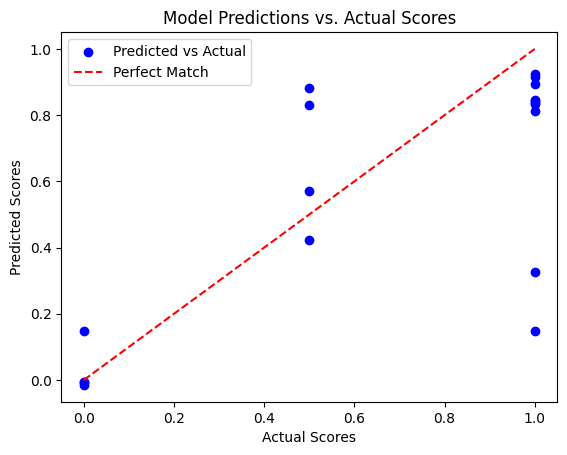

In [38]:
# Scatter plot of predictions vs. actual
import matplotlib.pyplot as plt

plt.scatter(y_val, predictions, c='blue', label='Predicted vs Actual')
plt.plot([0, 1], [0, 1], 'r--', label='Perfect Match')  # Reference line
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Model Predictions vs. Actual Scores')
plt.legend()
plt.show()

In [39]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

# Function to check if pivot is performed flat toward the circle center
def is_flat_pivot(ball_of_foot, heel):
    """
    Determines if the pivot is performed flat by analyzing the relative position 
    of the ball of the foot and the heel.
    Conditions:
    - The ball of the foot and heel should have minimal vertical displacement.
    - The foot should maintain a stable position on the ground.
    """
    ball_x, ball_y = ball_of_foot
    heel_x, heel_y = heel

    # Flat pivot condition: minimal vertical displacement between ball and heel
    pivot_detected = abs(ball_y - heel_y) < 0.02  # Small threshold for stability
    return pivot_detected

# Path for the new test video
new_video_path = "/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage4/test_videos/1_user10.mp4"

# Extract keypoints for the new video
new_keypoints = []
cap = cv2.VideoCapture(new_video_path)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB for MediaPipe processing
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark

        # Extract keypoints for pivot analysis
        left_ball_of_foot = [landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].x,
                             landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX].y]
        left_heel = [landmarks[mp_pose.PoseLandmark.LEFT_HEEL].x,
                     landmarks[mp_pose.PoseLandmark.LEFT_HEEL].y]

        right_ball_of_foot = [landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].x,
                              landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX].y]
        right_heel = [landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].x,
                      landmarks[mp_pose.PoseLandmark.RIGHT_HEEL].y]

        # Check for flat pivot on both feet
        left_pivot = is_flat_pivot(left_ball_of_foot, left_heel)
        right_pivot = is_flat_pivot(right_ball_of_foot, right_heel)

        # Store the binary values (0 or 1) for analysis
        new_keypoints.append([int(left_pivot), int(right_pivot)])

cap.release()

# Ensure the expected model shape
max_seq_length = 33  # Adjust to match training sequence length
expected_features = 1  # Ensure this matches model expectations

# Pad extracted keypoints
new_keypoints_padded = pad_sequences([new_keypoints], maxlen=max_seq_length, padding='post', dtype='float32')

# Handle feature mismatch by reducing dimensions if necessary
if new_keypoints_padded.shape[-1] != expected_features:
    # Reduce dimensions by summing or averaging across axis
    new_keypoints_padded = np.mean(new_keypoints_padded, axis=-1, keepdims=True)

# Reshape to match the model's input requirements
adjusted_input = new_keypoints_padded.reshape((1, max_seq_length, expected_features))

print(f"Final input shape for prediction: {adjusted_input.shape}")

# Predict score for the new video
try:
    predicted_score = model.predict(adjusted_input)
    print(f"Predicted Score: {predicted_score[0][0]:.2f}")
except Exception as e:
    print(f"Error during prediction: {e}")

I0000 00:00:1737674192.435964 12326183 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1737674192.495154 12497622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737674192.504004 12497622 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Final input shape for prediction: (1, 33, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Predicted Score: 0.67


In [40]:
print(X_train.shape[1])

109


In [49]:
def classify_score(prediction):
    """Classify the prediction into 0, 0.5, or 1 based on thresholds."""
    if prediction >= 0.7:
        return 1.0
    elif prediction >= 0.5:
        return 0.5
    else:
        return 0.0

In [50]:
# Predict scores on validation data
predictions = model.predict(X_val)

# Apply classification logic
classified_predictions = [classify_score(pred[0]) for pred in predictions]

# Print classified predictions vs actual scores
for i, (pred, actual) in enumerate(zip(classified_predictions, y_val)):
    print(f"Classified: {pred}, Actual: {actual}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 0.5
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 0.0
Classified: 1.0, Actual: 0.5
Classified: 0.0, Actual: 0.0
Classified: 0.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 0.5, Actual: 0.5
Classified: 1.0, Actual: 1.0
Classified: 0.0, Actual: 1.0
Classified: 0.0, Actual: 0.5
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0
Classified: 1.0, Actual: 1.0


In [51]:
import tensorflow.keras.backend as K

def weighted_mse(y_true, y_pred):
    """Weighted Mean Squared Error to prioritize true negatives."""
    weights = K.switch(y_true < 0.70, 2.0, 1.0)  # Weight true negatives higher
    return K.mean(weights * K.square(y_true - y_pred))

In [52]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=weighted_mse, metrics=['mae'])

In [53]:
# Predict and classify scores
classified_predictions = [classify_score(pred[0]) for pred in model.predict(X_val)]

# Evaluate accuracy of classification
correct = sum(1 for pred, actual in zip(classified_predictions, y_val) if pred == actual)
accuracy = correct / len(y_val)

print(f"Classification Accuracy: {accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Classification Accuracy: 0.72


In [54]:
model.save("/Users/danyukezz/Desktop/2 year 1 semester/team project/danya_preprocessing_sports/disc_throwing/stages/stage4/models/discus_stage4.keras")